In [ ]:
import logging

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

# Polyvore_DataSet.py

In [ ]:
import csv
import gzip
import itertools
import json
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import torchvision
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras import backend as K
from torch.optim import lr_scheduler
from torchvision import models
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/ML_Final_Project/data/train_no_dup_with_category_3more_name.json') as json_file:
    data = json.load(json_file)
    print(data)

{'100119331': {'accessory': {'index': 5, 'name': 'flower stud earrings red roses steel'}, 'bag': {'index': 4, 'name': 'studded denim backpack'}, 'bottom': {'index': 2, 'name': 'amanda jean'}, 'shoe': {'index': 3, 'name': 'converse chuck taylor star high-top sneaker'}, 'upper': {'index': 1, 'name': 'colors crop top tee'}}, '100050716': {'bag': {'index': 3, 'name': 'madden girl polka dot backpack'}, 'shoe': {'index': 2, 'name': 'beige crystal sandals'}, 'upper': {'index': 1, 'name': 'river island blue embroidered cut playsuit'}}, '100099673': {'accessory': {'index': 1, 'name': 'pink crystal pendant'}, 'bag': {'index': 2, 'name': 'padded'}, 'bottom': {'index': 5, 'name': 'h&m skinny low jeans'}, 'shoe': {'index': 6, 'name': 'ct leather low converse white'}, 'upper': {'index': 3, 'name': 'paris plain blue zipper'}}, '100176564': {'accessory': {'index': 7, 'name': 'oliver peoples sun'}, 'bag': {'index': 5, 'name': 'face leather school satchel'}, 'bottom': {'index': 3, 'name': 'studded super

In [ ]:
data_dir="/content/drive/MyDrive/ML_Final_Project/data/"
vocabulary, word_to_idx = [], {}
word_to_idx['UNK'] = len(word_to_idx)
vocabulary.append('UNK')
with open(data_dir+'final_word_dict.txt') as f:
    for line in f:
        name = line.strip().split()[0]
        if name not in word_to_idx:
            word_to_idx[name] = len(word_to_idx)
            vocabulary.append(name)

In [ ]:
def str_to_idx(str):
  return [word_to_idx[w] if w in word_to_idx else word_to_idx['UNK'] for w in name.split()]

In [ ]:
a = str_to_idx("burgundy stud shoulder crop knit jumper")

In [ ]:
print(a)

[2756]


In [ ]:
print(vocabulary)

['UNK', 'black', 'leather', 'bag', "women's", 'top', 'jeans', 'dress', 'gold', 'white', 'earrings', 'iphone', 'sunglasses', 'necklace', 'skirt', 'boots', 'suede', 'jacket', 'case', 'denim', 'ring', 'mini', 'yoins', 'high', 'blue', 'clutch', 'plus', 'bracelet', 'skinny', 'coat', 'shoulder', 'sandals', 'long', 'set', 'women', 'lace', 'red', 'new', 'print', 'pink', 'sleeve', 'ankle', 'silver', 'pre-owned', 'lipstick', 'shorts', 'topshop', 'sweater', 'size', 'faux', 'vintage', 'shoes', 'rose', 'pumps', 'de', 'michael', 'crop', 'color', 'eye', 'watch', 'shirt', 'round', 'backpack', 'diamond', 'brown', 'tote', 'velvet', 'floral', 'neck', 'lip', 'saint', 'laurent', 'cropped', 'stud', 'wool', 'blouse', 'sheinside', 'shein', 't-shirt', 'chanel', 'small', 'gucci', 'crossbody', 'fashion', 'kate', 'short', 'strap', 'star', 'classic', 'sneakers', 'womens', 'heel', 'cover', 'toe', 'kors', 'hat', 'nail', 'grey', 'chain', 'platform', 'boho', 'alexander', 'pants', 'flower', 'pearl', 'hair', 'dolce', 'c

In [ ]:
print(word_to_idx)

{'UNK': 0, 'black': 1, 'leather': 2, 'bag': 3, "women's": 4, 'top': 5, 'jeans': 6, 'dress': 7, 'gold': 8, 'white': 9, 'earrings': 10, 'iphone': 11, 'sunglasses': 12, 'necklace': 13, 'skirt': 14, 'boots': 15, 'suede': 16, 'jacket': 17, 'case': 18, 'denim': 19, 'ring': 20, 'mini': 21, 'yoins': 22, 'high': 23, 'blue': 24, 'clutch': 25, 'plus': 26, 'bracelet': 27, 'skinny': 28, 'coat': 29, 'shoulder': 30, 'sandals': 31, 'long': 32, 'set': 33, 'women': 34, 'lace': 35, 'red': 36, 'new': 37, 'print': 38, 'pink': 39, 'sleeve': 40, 'ankle': 41, 'silver': 42, 'pre-owned': 43, 'lipstick': 44, 'shorts': 45, 'topshop': 46, 'sweater': 47, 'size': 48, 'faux': 49, 'vintage': 50, 'shoes': 51, 'rose': 52, 'pumps': 53, 'de': 54, 'michael': 55, 'crop': 56, 'color': 57, 'eye': 58, 'watch': 59, 'shirt': 60, 'round': 61, 'backpack': 62, 'diamond': 63, 'brown': 64, 'tote': 65, 'velvet': 66, 'floral': 67, 'neck': 68, 'lip': 69, 'saint': 70, 'laurent': 71, 'cropped': 72, 'stud': 73, 'wool': 74, 'blouse': 75, 's

# Polyvore_Dataset.py

In [ ]:
# polyvore_dataset.py
class CategoryDataset(Dataset):
    """Dataset for polyvore with 5 categories(upper, bottom, shoe, bag, accessory),
    each suit has at least 3 items, the missing items will use a mean image.
    Args:
        root_dir: Directory stores source images
        data_file: A json file stores each outfit index and description
        data_dir: Directory stores data_file and mean_images
        transform: Operations to transform original images to fix size
        use_mean_img: Whether to use mean images to fill the blank part
        neg_samples: Whether generate negative sampled outfits
    """
    def __init__(self,
                 root_dir="/content/drive/MyDrive/ML_Final_Project/data/images/",
                 data_file="/content/drive/MyDrive/ML_Final_Project/data/train_no_dup_with_category_3more_name.json",
                 data_dir="/content/drive/MyDrive/ML_Final_Project/data/",
                 transform=None,
                 use_mean_img=True,
                 neg_samples=True):
        self.root_dir = root_dir
        self.data_dir = data_dir
        self.transform = transform
        self.use_mean_img = use_mean_img
        self.data = json.load(open(data_file))
        self.data = [(k, v) for k, v in self.data.items()]
        self.neg_samples = neg_samples # if True, will randomly generate negative outfit samples

        self.vocabulary, self.word_to_idx = [], {}
        self.word_to_idx['UNK'] = len(self.word_to_idx)
        self.vocabulary.append('UNK')
        with open(data_dir+'final_word_dict.txt') as f:
            for line in f:
                name = line.strip().split()[0]
                if name not in self.word_to_idx:
                    self.word_to_idx[name] = len(self.word_to_idx)
                    self.vocabulary.append(name)



    def __getitem__(self, index):
        """It could return a positive suits or negative suits"""
        set_id, parts = self.data[index]
        if random.randint(0, 1) and self.neg_samples:
            #to_change = random.sample(list(parts.keys()), 3) # random choose 3 negative items
            to_change = list(parts.keys()) # random choose negative items
        else:
            to_change = []
        imgs = []
        labels = []
        names = []
        print(parts.keys())
        for part in ['upper', 'bottom', 'shoe', 'bag', 'accessory']:
            if part in to_change: # random choose a image from dataset with same category
                choice = self.data[index]
                while (choice[0] == set_id) or (part not in choice[1].keys()):
                    choice = random.choice(self.data)
                img_path = os.path.join(self.root_dir, str(choice[0]), str(choice[1][part]['index'])+'.jpg')
                names.append(torch.LongTensor(self.str_to_idx(choice[1][part]['name'])))
                labels.append('{}_{}'.format(choice[0], choice[1][part]['index']))
            elif part in parts.keys():
                img_path = os.path.join(self.root_dir, str(set_id), str(parts[part]['index'])+'.jpg')
                print(img_path)
                print(self.str_to_idx(parts[part]['name']))
                print("Name Tensor: ", self.str_to_idx(parts[part]['name']))
                print(torch.LongTensor(self.str_to_idx(parts[part]['name'])))
                names.append(torch.LongTensor(self.str_to_idx(parts[part]['name'])))
                labels.append('{}_{}'.format(set_id, parts[part]['index']))
            elif self.use_mean_img:
                img_path = os.path.join(self.data_dir, part+'.png')
                print("Other image: ", img_path)
                names.append(torch.LongTensor([])) # mean_img embedding
                labels.append('{}_{}'.format(part, 'mean'))
            else:
                continue
            img = Image.open(img_path).convert('RGB')
            img = self.transform(img)
            imgs.append(img)
        input_images = torch.stack(imgs)
        is_compat = (len(to_change)==0)

        offsets = list(itertools.accumulate([0] + [len(n) for n in names[:-1]]))
        offsets = torch.LongTensor(offsets)
        return input_images, names, offsets, set_id, labels, is_compat

    def __len__(self):
        return len(self.data)

    def str_to_idx(self, name):
        return [self.word_to_idx[w] if w in self.word_to_idx else self.word_to_idx['UNK']
            for w in name.split()]

### Do we have the fill in the blanks???????? ##parisa
    def get_fitb_quesiton(self, index):
        """Generate fill in th blank questions.
        Return:
            images: 5 parts of a outfit
            labels: store if this item is empty
            question_part: which part to be changed
            options: 3 other item with the same category,
                expect original composition get highest score
        """
        set_id, parts = self.data[index]
        question_part = random.choice(list(parts))
        question_id = "{}_{}".format(set_id, parts[question_part]['index'])
        imgs = []
        labels = []
        for part in ['upper', 'bottom', 'shoe', 'bag', 'accessory']:
            if part in parts.keys():
                img_path = os.path.join(self.root_dir, str(set_id), str(parts[part]['index'])+'.jpg')
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img)
                imgs.append(img)
                labels.append('{}_{}'.format(set_id, parts[part]['index']))
            elif self.use_mean_img:
                img_path = os.path.join(self.data_dir, part+'.png')
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img)
                imgs.append(img)
                labels.append('{}_{}'.format(part, 'mean'))
        items = torch.stack(imgs)

        option_ids = [set_id]
        options = []
        option_labels = []
        while len(option_ids) < 4:
            option = random.choice(self.data)
            if (option[0] in option_ids) or (question_part not in option[1]):
                continue
            else:
                option_ids.append(option[0])
                img_path = os.path.join(self.root_dir, \
                                        str(option[0]), \
                                        str(option[1][question_part]['index'])+'.jpg')
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img)
                options.append(img)
                option_labels.append("{}_{}".format(option[0], option[1][question_part]['index']))

        # Return 4 options for question, 3 incorrect options
        return items, labels, question_part, question_id, options, option_labels

def collate_fn(data):
    """Need custom a collate_fn"""
    data.sort(key=lambda x:x[0].shape[0], reverse=True)
    images,  names, offsets, set_ids, labels, is_compat = zip(*data)
    lengths = [i.shape[0] for i in images]
    is_compat = torch.LongTensor(is_compat)
    names = sum(names, [])
    offsets = list(offsets)
    images = torch.stack(images)
    return (
        lengths,
        images,
        names,
        offsets,
        set_ids,
        labels,
        is_compat
    )

def lstm_collate_fn(data):
    """Need custom a collate_fn for LSTM DataLoader
    Batch images will be transformed to a long sequence.
    """
    data.sort(key=lambda x:x[0].shape[0], reverse=True)
    images,  names, offsets, set_ids, labels, is_compat = zip(*data)
    lengths = [i.shape[0] for i in images]
    names = sum(names, [])
    offsets = list(offsets)
    images = torch.cat(images)
    return (
        lengths,
        images,
        names,
        offsets,
        set_ids,
        labels,
        is_compat
    )


class TripletDataset(Dataset):
    """Dataset will generate triplet to train conditional similarity network. Each
     element in dataset should be anchor image, positive image, negative image and condition.

     Args:
         root_dir: Image directory
         data_file: A file record all outfit id and items
         data_dir: Directory which save mean image and data_file
         transform:
         is_train: Train phase will genrate triplet and condition, Evaluate phase will generate
             pair, condition and target.
     """
    def __init__(self,
             root_dir="/export/home/wangx/datasets/polyvore-dataset/images/",
             data_file='/content/drive/MyDrive/ML_Final_Project/data/train_no_dup_with_category_3more_name.json',
             data_dir="/content/drive/MyDrive/ML_Final_Project/data/",
             transform=None,
             is_train=True):
        self.root_dir = root_dir
        self.data_dir = data_dir
        self.transform = transform
        self.data = json.load(open(os.path.join(data_dir, data_file)))
        self.data = [(k, v) for k, v in self.data.items()]
        self.is_train = is_train
        self.conditions = {
            'upper_bottom': 0,
            'bottom_upper': 0,
            'upper_shoe': 1,
            'shoe_upper': 1,
            'upper_bag': 2,
            'bag_upper': 2,
            'upper_accessory': 3,
            'accessory_upper': 3,
            'bottom_shoe': 4,
            'shoe_bottom': 4,
            'bottom_bag': 5,
            'bag_bottom': 5,
            'bottom_accessory': 6,
            'accessory_bottom': 6,
            'shoe_bag': 7,
            'bag_shoe': 7,
            'shoe_accessory': 8,
            'accessory_shoe': 8,
            'bag_accessory': 9,
            'accessory_bag': 9,
        }

    def load_img(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        return img

    def __getitem__(self, index):
        set_id, parts = self.data[index]
        choice = random.sample(list(parts.keys()), k=2)
        anchor_part, pos_part = choice[0], choice[1]
        anchor_img_path = os.path.join(self.root_dir, str(set_id), str(parts[anchor_part]['index'])+'.jpg')
        pos_img_path = os.path.join(self.root_dir, str(set_id), str(parts[pos_part]['index'])+'.jpg')

        neg_choice = self.data[index]
        while (pos_part not in neg_choice[1]) or (neg_choice[0] == set_id):
            neg_choice = random.choice(self.data)
        neg_img_path = os.path.join(self.root_dir, str(neg_choice[0]), str(neg_choice[1][pos_part]['index'])+'.jpg')

        pos_img = self.load_img(pos_img_path)
        anchor_img = self.load_img(anchor_img_path)
        neg_img = self.load_img(neg_img_path)

        condition = self.conditions['_'.join(choice)]

        if self.is_train:
            return anchor_img, pos_img, neg_img, condition
        else:
            target = random.randint(0, 1)
            if target == 0:
                return anchor_img, pos_img, target, condition
            elif target == 1:
                return anchor_img, neg_img, target, condition

    def __len__(self):
        return len(self.data)

# Utils.py

In [ ]:
import logging

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset

In [ ]:
# utils.py
class AverageMeter(object):
    """Computes and stores the average and current value.
    >>> acc = AverageMeter()
    >>> acc.update(0.6)
    >>> acc.update(0.8)
    >>> print(acc.avg)
    0.7
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class BestSaver(object):
    """Save pytorch model with best performance. Template for save_path is:
        model_{save_path}_{comment}.pth
    >>> comment = "v1"
    >>> saver = BestSaver(comment)
    >>> auc = 0.6
    >>> saver.save(0.6, model.state_dict())
    """
    def __init__(self, comment=None):
        # Get current executing script name
        import __main__, os
        save_path = "./model"

        if comment is not None and str(comment):
            save_path = save_path + "_" + str(comment)

        save_path = save_path + ".pth"

        self.save_path = save_path
        self.best = float('-inf')

    def save(self, metric, data):
        if metric > self.best:
            self.best = metric
            torch.save(data, self.save_path)
            logging.info("Saved best model to {}".format(self.save_path))


def config_logging(comment=None):
    """Configure logging for training log. The format is
        `log_{log_fname}_{comment}.log`
    .g. for `train.py`, the log_fname is `log_train.log`.
    Use `logging.info(...)` to record running log.
    Args:
        comment (any): Append comment for log_fname
    """

    # Get current executing script name
    import __main__, os
    log_fname = "./logger"

    if comment is not None and str(comment):
        log_fname = log_fname + "_" + str(comment)

    log_fname = log_fname + ".log"
    log_format = "%(asctime)s [%(levelname)-5.5s] %(message)s"

    logging.basicConfig(
        level=logging.INFO,
        format=log_format,
        handlers=[logging.FileHandler(log_fname), logging.StreamHandler()]
    )

def prepare_dataloaders(root_dir="/content/drive/MyDrive/ML_Final_Project/data/images/", data_dir="/content/drive/MyDrive/ML_Final_Project/data/", batch_size=16, img_size=224, use_mean_img=True, neg_samples=True, num_workers=1, collate_fn=collate_fn):
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((img_size, img_size)),
            torchvision.transforms.ToTensor(),
        ]
    )
    train_dataset = CategoryDataset(
        root_dir=root_dir,
        data_dir=data_dir,
        transform=transform,
        use_mean_img=use_mean_img,
        data_file="/content/drive/MyDrive/ML_Final_Project/data/train_no_dup_with_category_3more_name.json",
    )

    print("Reaching")
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn
    )
    val_dataset = CategoryDataset(
        root_dir=root_dir,
        data_dir=data_dir,
        transform=transform,
        use_mean_img=use_mean_img,
        data_file="/content/drive/MyDrive/ML_Final_Project/data/valid_no_dup_with_category_3more_name.json",
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn
    )
    test_dataset = CategoryDataset(
        root_dir=root_dir,
        data_dir=data_dir,
        transform=transform,
        use_mean_img=use_mean_img,
        data_file="/content/drive/MyDrive/ML_Final_Project/data/test_no_dup_with_category_3more_name.json",
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn
    )
    return train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader

# Resnet.py

## Identity Block
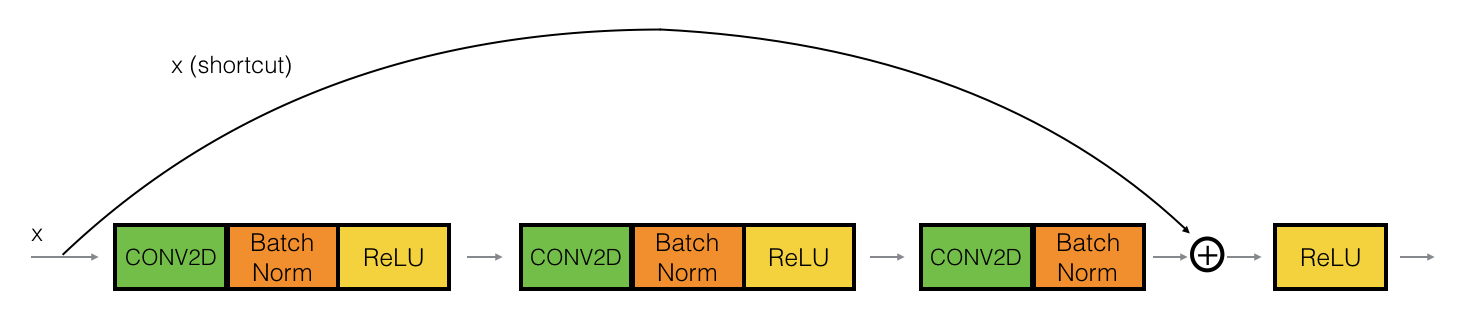

In [ ]:
def identity_Block(X, ks, filters, block, stage):

  #Get filters
  f1,f2,f3=filters

  #Name
  conv_name = 'Res'+str(stage)+block+'_'
  batch_name = 'BN'+str(stage)+block+'_'

  #Skip connection
  skip_conn = X


  #Block A
  X = Conv2D(filters=f1,kernel_size=(1,1),strides=(1,1),name=conv_name+'a', padding="valid",kernel_initializer=glorot_uniform(seed=1))(X)
  X = BatchNormalization(axis=3,name=batch_name+'a')(X)
  X = Activation('relu')(X)

  #Block B
  X = Conv2D(filters=f2,kernel_size=(ks,ks),strides=(1,1),name=conv_name+'b', padding="same",kernel_initializer=glorot_uniform(seed=1))(X)
  X = BatchNormalization(axis=3,name=batch_name+'b')(X)
  X = Activation('relu')(X)

  #Block C
  X = Conv2D(filters=f3,kernel_size=(1,1),strides=(1,1),name=conv_name+'c', padding="valid",kernel_initializer=glorot_uniform(seed=1))(X)
  X = BatchNormalization(axis=3,name=batch_name+'c')(X)

  #Add skip connection
  X = Add()([X,skip_conn])

  #Final Activation
  X = Activation('relu')(X)

  return X

#Convolution Block
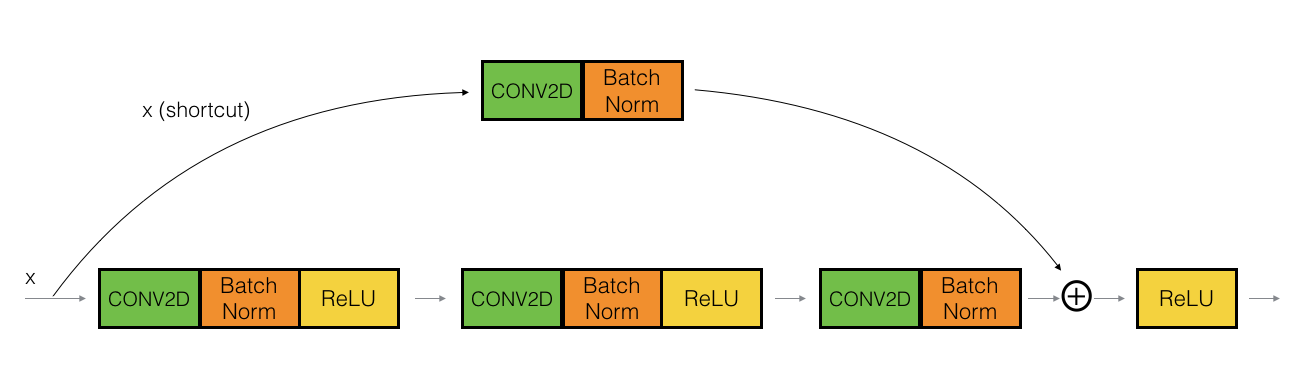

In [ ]:
def conv_Block(X, ks, filters, block, stage, stride=2):

    f1,f2,f3 = filters
    conv_name = 'Res'+str(stage)+block+'_'
    batch_name = 'BN'+str(stage)+block+'_'
    skip_conn = X

    #Block A
    X = Conv2D(filters=f1,kernel_size=(1,1),strides=(stride,stride),name=conv_name+'a', padding="valid",kernel_initializer=glorot_uniform(seed=1))(X)
    X = BatchNormalization(axis=3,name=batch_name+'a')(X)
    X = Activation('relu')(X)

    #Block B
    X = Conv2D(filters=f2,kernel_size=(ks,ks),strides=(1,1),name=conv_name+'b', padding="same",kernel_initializer=glorot_uniform(seed=1))(X)
    X = BatchNormalization(axis=3,name=batch_name+'b')(X)
    X = Activation('relu')(X)

    #Block C
    X = Conv2D(filters=f3,kernel_size=(1,1),strides=(1,1),name=conv_name+'c', padding="valid",kernel_initializer=glorot_uniform(seed=1))(X)
    X = BatchNormalization(axis=3,name=batch_name+'c')(X)

    #Skip Connection
    X_skip = Conv2D(filters=f3,kernel_size=(1,1),strides=(stride,stride),name=conv_name+'1', padding="valid",kernel_initializer=glorot_uniform(seed=1))(skip_conn)
    X_skip =  BatchNormalization(axis=3,name=batch_name+'1')(X_skip)

    #Add skip connection
    X = Add()([X,X_skip])

    X = Activation('relu')(X)

    return X

##ResNet Model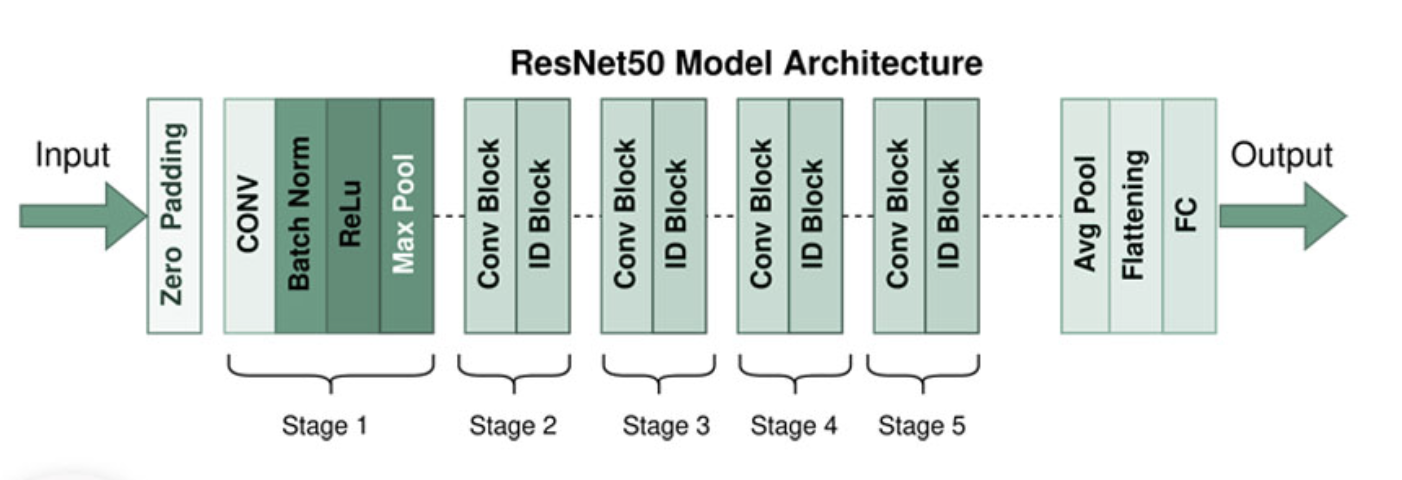

In [ ]:
def bulid_resNet50(input_shape=(224,224,3), get_rep=False):

    input = Input(input_shape)

    #Add zero padding
    X = ZeroPadding2D((3,3))(input)

    #Stage 1
    X = Conv2D(64,(7,7),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=1))(X)
    X = BatchNormalization(axis=3, name='conv1_BN')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides=(2,2))(X)

    #Stage 2
    X = conv_Block(X, ks=3, filters=[64,64,256], block='a', stage=2, stride=1)
    X = identity_Block(X, ks=3, filters=[64,64,256], block='b', stage=2)
    X = identity_Block(X, ks=3, filters=[64,64,256], block='c', stage=2)


    #Stage 3
    X = conv_Block(X, ks=3, filters=[128,128,512], block='a', stage=3, stride=2)
    X = identity_Block(X, ks=3, filters=[128,128,512], block='b', stage=3)
    X = identity_Block(X, ks=3, filters=[128,128,512], block='c', stage=3)
    X = identity_Block(X, ks=3, filters=[128,128,512], block='d', stage=3)

    #Stage 4
    X = conv_Block(X, ks=3, filters=[256,256,1024], block='a', stage=4, stride=2)
    X = identity_Block(X, ks=3, filters=[256,256,1024], block='b', stage=4)
    X = identity_Block(X, ks=3, filters=[256,256,1024], block='c', stage=4)
    X = identity_Block(X, ks=3, filters=[256,256,1024], block='d', stage=4)
    X = identity_Block(X, ks=3, filters=[256,256,1024], block='e', stage=4)
    X = identity_Block(X, ks=3, filters=[256,256,1024], block='f', stage=4)

    #Stage 5
    X = conv_Block(X, ks=3, filters=[512,512,2048], block='a', stage=5, stride=2)
    X = identity_Block(X, ks=3, filters=[512,512,2048], block='b', stage=5)
    X = identity_Block(X, ks=3, filters=[512,512,2048], block='c', stage=5)

    #Create model
    model = Model(inputs=input,outputs=X,name='ResNet50')

    return model

In [ ]:
resnet50_url='https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

#Construct the ResNet-50 model
def resnet50(pre_trained=False, embedd_size):
    base_model = bulid_resNet50()
    headModel = base_model.output
    headModel=Dense(embedd_size, name='fc1',kernel_initializer=glorot_uniform(seed=1))(headModel)
    model = Model(inputs=base_model.input, outputs=headModel)
    if pre_trained:
      weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', resnet50_url,cache_subdir='models',md5_hash='a268eb855778b3df3c7506639542a6af')
      model.load_weights(weights_path, by_name=True)
    return model

SyntaxError: ignored

In [ ]:
def build_LSTM(hidden_features,input_shape):
  input = Input(shape=(input_shape))
  lstm=LSTM(units=hidden_features,return_sequences = False)(input)
  drop = Dropout(0.3)(lstm)
  bn = BatchNormalization()(drop)
  model = Model(inputs=input, outputs=bn)
  return model

# Model.py

In [ ]:


import itertools

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torchvision.models as models


In [ ]:
class CompatModel(nn.Module):
    def __init__(
            self,
            embed_size=1000,
            need_rep=False,
            vocabulary=None,
            vse_off=False,
            pe_off=False,
            mlp_layers=2,
            conv_feats="1234",
        ):
        """The Multi-Layered Comparison Network (MCN) for outfit compatibility
        prediction and diagnosis.
        Args:
            embed_size: the output embedding size of the cnn model, default 1000.
            need_rep: whether to output representation of the layer before last fc
                layer, whose size is 2048. This representation can be used for
                compute the Visual Sementic Embedding (VSE) loss.
            vocabulary: the counts of words in the polyvore dataset.
            vse_off: whether use visual semantic embedding.
            pe_off: whether use projected embedding.
            mlp_layers: number of mlp layers used in the last predictor part.
            conv_feats: decide which layer of conv features are used for comparision.
        """
        super(CompatModel, self).__init__()
        self.vse_off = vse_off
        self.pe_off = pe_off
        self.mlp_layers = mlp_layers
        self.conv_feats = conv_feats

        cnn = resnet50(pre_trained=True)
        cnn.fc = nn.Linear(cnn.fc.in_features, embed_size)
        self.cnn = cnn
        self.need_rep = need_rep
        self.num_rela = 15 * len(conv_feats)
        self.bn = nn.BatchNorm1d(self.num_rela)  # 5x5 relationship matrix have 25 elements

        # Define predictor part
        if self.mlp_layers > 0:
            predictor = []
            for _ in range(self.mlp_layers-1):
                linear = nn.Linear(self.num_rela, self.num_rela)
                nn.init.xavier_uniform_(linear.weight)
                nn.init.constant_(linear.bias, 0)
                predictor.append(linear)
                predictor.append(nn.ReLU())
            linear = nn.Linear(self.num_rela, 1)
            nn.init.xavier_uniform_(linear.weight)
            nn.init.constant_(linear.bias, 0)
            predictor.append(linear)
            self.predictor = nn.Sequential(*predictor)
        self.sigmoid = nn.Sigmoid()

        nn.init.xavier_uniform_(cnn.fc.weight)
        nn.init.constant_(cnn.fc.bias, 0)

        # Type specified masks
        # l1, l2, l3 is the masks for feature maps for the beginning layers
        # not suffix one is for the last layer
        self.masks = nn.Embedding(15, embed_size)
        self.masks.weight.data.normal_(0.9, 0.7)
        self.masks_l1 = nn.Embedding(15, 256)
        self.masks_l1.weight.data.normal_(0.9, 0.7)
        self.masks_l2 = nn.Embedding(15, 512)
        self.masks_l2.weight.data.normal_(0.9, 0.7)
        self.masks_l3 = nn.Embedding(15, 1024)
        self.masks_l3.weight.data.normal_(0.9, 0.7)

        # Semantic embedding model
        self.sem_embedding = nn.Embedding(vocabulary, 1000)
        # Visual embedding model
        self.image_embedding = nn.Linear(2048, 1000)

        # Global average pooling layer
        self.ada_avgpool2d = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, images, names):
        """
        Args:
            images: Outfit images with shape (N, T, C, H, W)
            names: Description words of each item in outfit
        Return:
            out: Compatibility score
            vse_loss: Visual Semantic Loss
            tmasks_loss: mask loss to encourage a sparse mask
            features_loss: regularize the feature vector to be normal
        """
        if self.need_rep:
            out, features, tmasks, rep = self._compute_score(images)
        else:
            out, features, tmasks = self._compute_score(images)

        if self.vse_off:
            vse_loss = torch.tensor(0.)
        else:
            vse_loss = self._compute_vse_loss(names, rep)
        if self.pe_off:
            tmasks_loss, features_loss = torch.tensor(0.), torch.tensor(0.)
        else:
            tmasks_loss, features_loss = self._compute_type_repr_loss(tmasks, features)

        return out, vse_loss, tmasks_loss, features_loss

    def _compute_vse_loss(self, names, rep):
        """ Visual semantice loss which map both visual embedding and semantic embedding
        into a common space.
        Reference:
        https://github.com/xthan/polyvore/blob/e0ca93b0671491564b4316982d4bfe7da17b6238/polyvore/polyvore_model_bi.py#L362
        """
        # Normalized Semantic Embedding
        padded_names = rnn_utils.pad_sequence(names, batch_first=True).to(rep.device)
        mask = torch.gt(padded_names, 0)
        cap_mask = torch.ge(mask.sum(dim=1), 2)
        semb = self.sem_embedding(padded_names)
        semb = semb * (mask.unsqueeze(dim=2)).float()
        word_lengths = mask.sum(dim=1)
        word_lengths = torch.where(
            word_lengths == 0,
            (torch.ones(semb.shape[0]).float() * 0.1).to(rep.device),
            word_lengths.float(),
        )
        semb = semb.sum(dim=1) / word_lengths.unsqueeze(dim=1)
        semb = F.normalize(semb, dim=1)

        # Normalized Visual Embedding
        vemb = F.normalize(self.image_embedding(rep), dim=1)

        # VSE Loss
        semb = torch.masked_select(semb, cap_mask.unsqueeze(dim=1))
        vemb = torch.masked_select(vemb, cap_mask.unsqueeze(dim=1))
        semb = semb.reshape([-1, 1000])
        vemb = vemb.reshape([-1, 1000])
        scores = torch.matmul(semb, vemb.transpose(0, 1))
        diagnoal = scores.diag().unsqueeze(dim=1)
        cost_s = torch.clamp(0.2 - diagnoal + scores, min=0, max=1e6)  # 0.2 is margin
        cost_im = torch.clamp(0.2 - diagnoal.transpose(0, 1) + scores, min=0, max=1e6)
        cost_s = cost_s - torch.diag(cost_s.diag())
        cost_im = cost_im - torch.diag(cost_im.diag())
        vse_loss = cost_s.sum() + cost_im.sum()
        vse_loss = vse_loss / (semb.shape[0] ** 2)

        return vse_loss

    def _compute_type_repr_loss(self, tmasks, features):
        """ Here adopt two losses to improve the type-spcified represetations.
        `tmasks_loss` expect the masks to be sparse and `features_loss` regularize
        the feature vector to be a unit vector.
        Reference:
        Conditional Similarity Networks: https://arxiv.org/abs/1603.07810
        """
        # Type embedding loss
        tmasks_loss = tmasks.norm(1) / len(tmasks)
        features_loss = features.norm(2) / np.sqrt(
            (features.shape[0] * features.shape[1])
        )
        return tmasks_loss, features_loss

    def _compute_score(self, images, activate=True):
        """Extract feature vectors from input images.
        Return:
            out: the compatibility score
            features: the visual embedding of the images, we use 1000-d in all experiments
            masks: the mask for type-specified embedding
            rep: the represtions of the second last year, which is 2048-d for resnet-50 backend
        """
        batch_size, item_num, _, _, img_size = images.shape
        images = torch.reshape(images, (-1, 3, img_size, img_size))
        if self.need_rep:
            features, *rep = self.cnn(images)
            rep_l1, rep_l2, rep_l3, rep_l4, rep = rep
        else:
            features = self.cnn(images)

        relations = []
        features = features.reshape(batch_size, item_num, -1)  # (32, 5, 1000)
        masks = F.relu(self.masks.weight)
        # Comparison matrix
        if "4" in self.conv_feats:
            for mi, (i, j) in enumerate(itertools.combinations_with_replacement([0,1,2,3,4], 2)):
                if self.pe_off:
                    left = F.normalize(features[:, i:i+1, :], dim=-1) # (32, 1, 1000)
                    right = F.normalize(features[:, j:j+1, :], dim=-1)
                else:
                    left = F.normalize(masks[mi] * features[:, i:i+1, :], dim=-1) # (32, 1, 1000)
                    right = F.normalize(masks[mi] * features[:, j:j+1, :], dim=-1)
                rela = torch.matmul(left, right.transpose(1, 2)).squeeze() # (32)
                relations.append(rela)

        # Comparision at Multi-Layered representations
        rep_list = []
        masks_list = []
        if "1" in self.conv_feats:
            rep_list.append(rep_l1); masks_list.append(self.masks_l1)
        if "2" in self.conv_feats:
            rep_list.append(rep_l2); masks_list.append(self.masks_l2)
        if "3" in self.conv_feats:
            rep_list.append(rep_l3); masks_list.append(self.masks_l3)
        for rep_li, masks_li in zip(rep_list, masks_list):
            rep_li = self.ada_avgpool2d(rep_li).squeeze().reshape(batch_size, item_num, -1)
            masks_li = F.relu(masks_li.weight)
            # Enumerate all pairwise combination among the outfit then compare their features
            for mi, (i, j) in enumerate(itertools.combinations_with_replacement([0,1,2,3,4], 2)):
                if self.pe_off:
                    left = F.normalize(masks_li[mi] * rep_li[:, i:i+1, :], dim=-1) # (32, 1, 1000)
                    right = F.normalize(masks_li[mi] * rep_li[:, j:j+1, :], dim=-1)
                else:
                    left = F.normalize(masks_li[mi] * rep_li[:, i:i+1, :], dim=-1) # (32, 1, 1000)
                    right = F.normalize(masks_li[mi] * rep_li[:, j:j+1, :], dim=-1)
                rela = torch.matmul(left, right.transpose(1, 2)).squeeze() # (32)
                relations.append(rela)

        if batch_size == 1: # Inference during evaluation, which input one sample
            relations = torch.stack(relations).unsqueeze(0)
        else:
            relations = torch.stack(relations, dim=1) # (32 ,15*4)
        relations = self.bn(relations)

        # Predictor
        if self.mlp_layers == 0:
            out = relations.mean(dim=-1, keepdim=True)
        else:
            out = self.predictor(relations)

        if activate:
            out = self.sigmoid(out)
        if self.need_rep:
            return out, features, masks, rep
        else:
            return out, features, masks

In [ ]:
trained_model = CompatModel()

NameError: ignored

# Train.py

In [ ]:
# train.py

comment = ""
vse_off = "store_true"
pe_off = "store_true"
mlp_layers = 2
conv_feats = "1234"

# Logger
config_logging(comment)

# Dataloader
train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader = (prepare_dataloaders(batch_size=16))

# Device
device = torch.device("cuda:0")

# Model
model = CompatModel(embed_size=1000, need_rep=True, vocabulary=len(train_dataset.vocabulary),
                    vse_off=vse_off, pe_off=pe_off, mlp_layers=mlp_layers, conv_feats=conv_feats)

# print((model))

# Train process
def train(model, device, train_loader, val_loader, comment):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    saver = BestSaver(comment)
    epochs = 1
    for epoch in range(1, epochs + 1):
        logging.info("Train Phase, Epoch: {}".format(epoch))
        scheduler.step()
        total_losses = AverageMeter()
        clf_losses = AverageMeter()
        vse_losses = AverageMeter()
        # Train phase
        model.train()
        print("Train Loader")
        for batch_num, batch in enumerate(train_loader, 1):
          print("Hi")
          print(batch_num, batch)

        for batch_num, batch in enumerate(train_loader, 1):
            lengths, images, names, offsets, set_ids, labels, is_compat = batch
            images = images.to(device)

            # Forward
            output, vse_loss, tmasks_loss, features_loss = model(images, names)

            # BCE Loss
            target = is_compat.float().to(device)
            output = output.squeeze(dim=1)
            clf_loss = criterion(output, target)

            # Sum all losses up
            features_loss = 5e-3 * features_loss
            tmasks_loss = 5e-4 * tmasks_loss
            total_loss = clf_loss + vse_loss + features_loss + tmasks_loss

            # Update Recoder
            total_losses.update(total_loss.item(), images.shape[0])
            clf_losses.update(clf_loss.item(), images.shape[0])
            vse_losses.update(vse_loss.item(), images.shape[0])

            # Backpropagation
            model.zero_grad()
            total_loss.backward()
            optimizer.step()
            if batch_num % 10 == 0:
                logging.info(
                    "[{}/{}] #{} clf_loss: {:.4f}, vse_loss: {:.4f}, features_loss: {:.4f}, tmasks_loss: {:.4f}, total_loss:{:.4f}".format(
                        epoch, epochs, batch_num, clf_losses.val, vse_losses.val, features_loss, tmasks_loss, total_losses.val
                    )
                )
        logging.info("Train Loss (clf_loss): {:.4f}".format(clf_losses.avg))

        # Valid Phase
        logging.info("Valid Phase, Epoch: {}".format(epoch))
        model.eval()
        clf_losses = AverageMeter()
        outputs = []
        targets = []
        for batch_num, batch in enumerate(val_loader, 1):
            lengths, images, names, offsets, set_ids, labels, is_compat = batch
            images = images.to(device)
            target = is_compat.float().to(device)
            with torch.no_grad():
                output, _, _, _ = model._compute_score(images)
                output = output.squeeze(dim=1)
                clf_loss = criterion(output, target)
            clf_losses.update(clf_loss.item(), images.shape[0])
            outputs.append(output)
            targets.append(target)
        logging.info("Valid Loss (clf_loss): {:.4f}".format(clf_losses.avg))
        outputs = torch.cat(outputs).cpu().data.numpy()
        targets = torch.cat(targets).cpu().data.numpy()
        auc = metrics.roc_auc_score(targets, outputs)
        logging.info("AUC: {:.4f}".format(auc))
        predicts = np.where(outputs > 0.5, 1, 0)
        accuracy = metrics.accuracy_score(predicts, targets)
        logging.info("Accuracy@0.5: {:.4f}".format(accuracy))
        positive_loss = -np.log(outputs[targets==1]).mean()
        logging.info("Positive loss: {:.4f}".format(positive_loss))
        positive_acc = sum(outputs[targets==1]>0.5) / len(outputs)
        logging.info("Positive accuracy: {:.4f}".format(positive_acc))

        # Save best model
        saver.save(auc, model.state_dict())

Reaching
5
2
2
1
2
2
1
2
2
1
2
5
2
2
1
2
2
1
2
2
1
2
2
1
2
5
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
5
2
2
1
2
2
1
2


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


2
1
2


In [ ]:
train(model, device, train_loader, val_loader, comment)

Train Loader


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


dict_keys(['accessory', 'bag', 'bottom', 'shoe', 'upper'])
dict_keys(['bag', 'bottom', 'upper'])
/content/drive/MyDrive/ML_Final_Project/data/images/100167523/1.jpg
[418, 73, 30, 56, 129, 208]
Name Tensor:  [418, 73, 30, 56, 129, 208]
tensor([418,  73,  30,  56, 129, 208])
/content/drive/MyDrive/ML_Final_Project/data/images/100167523/2.jpg
[36, 919, 452, 297, 14]
Name Tensor:  [36, 919, 452, 297, 14]
tensor([ 36, 919, 452, 297,  14])
Other image:  /content/drive/MyDrive/ML_Final_Project/data/shoe.png
/content/drive/MyDrive/ML_Final_Project/data/images/100167523/3.jpg
[101, 232, 30, 3]
Name Tensor:  [101, 232, 30, 3]
tensor([101, 232,  30,   3])
Other image:  /content/drive/MyDrive/ML_Final_Project/data/accessory.png
dict_keys(['bag', 'shoe', 'upper'])
Other image:  /content/drive/MyDrive/ML_Final_Project/data/bottom.png
Other image:  /content/drive/MyDrive/ML_Final_Project/data/accessory.png
dict_keys(['bag', 'bottom', 'shoe', 'upper'])
/content/drive/MyDrive/ML_Final_Project/data/imag

In [ ]:
torch.LongTensor()

tensor([], dtype=torch.int64)

#OutfitSequencer

In [ ]:
class OutfitSequencer(tf.keras.utils.Sequence):
    def __init__(self,
                 batch_size,
                 root_dir="/content/drive/MyDrive/ML_Final_Project/data/images/",
                 data_file="/content/drive/MyDrive/ML_Final_Project/data/train_no_dup_with_category_3more_name.json",
                 data_dir="/content/drive/MyDrive/ML_Final_Project/data/",
                 transform=None,
                 use_mean_img=True,
                 neg_samples=True):
        self.batch_size = batch_size
        self.root_dir = root_dir
        self.data_dir = data_dir
        self.transform = transform
        self.use_mean_img = use_mean_img

        # extracting and storing training samples as a list
        self.data = json.load(open(data_file))
        self.data = [(k, v) for k, v in self.data.items()]

        self.neg_samples = neg_samples # if True, will randomly generate negative outfit samples

        # datalength
        self.dataLen = len(self.data)


        self.vocabulary, self.word_to_idx = [], {}
        self.word_to_idx['UNK'] = len(self.word_to_idx)
        self.vocabulary.append('UNK')
        with open(data_dir+'final_word_dict.txt') as f:
            for line in f:
                name = line.strip().split()[0]
                if name not in self.word_to_idx:
                    self.word_to_idx[name] = len(self.word_to_idx)
                    self.vocabulary.append(name)


    def transform(self, image, dim):
        # resize
        tf.image.resize_images(image, [dim, dim])
        return image


    def image_loader(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = transform(image)
        # converting it tensor
        image = tf.cast(image, tf.float32)
        image = tf.expand_dims(image, 0)
        return image

    def on_epoch_end(self):
        # Updates indexes after each epoch
        seed = np.random.randint()
        self.data = shuffle(self.data, random_state=seed)


    def run_for_each_item(self, set_id, parts):
        if random.randint(0, 1) and self.neg_samples:
            #to_change = random.sample(list(parts.keys()), 3) # random choose 3 negative items
            to_change = list(parts.keys()) # random choose negative items
        else:
            to_change = []
        imgs = []
        labels = []
        names = []
        for part in ['upper', 'bottom', 'shoe', 'bag', 'accessory']:
            if part in to_change: # random choose a image from dataset with same category
                choice = self.data[index]
                while (choice[0] == set_id) or (part not in choice[1].keys()):
                    choice = random.choice(self.data)
                img_path = os.path.join(self.root_dir, str(choice[0]), str(choice[1][part]['index'])+'.jpg')
                names.append(tf.constant(self.str_to_idx(choice[1][part]['name']), dtype=tf.float64))
                labels.append('{}_{}'.format(choice[0], choice[1][part]['index']))
            elif part in parts.keys():
                img_path = os.path.join(self.root_dir, str(set_id), str(parts[part]['index'])+'.jpg')
                names.append(tf.constant(self.str_to_idx(choice[1][part]['name']), dtype=tf.float64))
                labels.append('{}_{}'.format(set_id, parts[part]['index']))
            elif self.use_mean_img:
                img_path = os.path.join(self.data_dir, part+'.png')
                names.append(tf.constant([], dtype=tf.float64)) # mean_img embedding
                labels.append('{}_{}'.format(part, 'mean'))
            else:
                continue
            img = self.image_loader(img_path)
            imgs.append(img)
        input_images = tf.concat(imgs, 0)
        is_compat = (len(to_change)==0)

        offsets = list(itertools.accumulate([0] + [len(n) for n in names[:-1]]))
        offsets = tf.constant(offsets, dtype=tf.float64)
        return input_images, names, offsets, set_id, labels, is_compat


    def __getitem__(self, index):
        """It could return a positive suits or negative suits"""
        batch = []

        indices = self.indexs[np.arange(x, x+self.batch_size)]

        for index in indices:
            set_id, parts = self.data[index]
            batch.append(self.run_for_each_item(set_id, parts))

        return tf.convert_to_tensor(batch)


    def str_to_idx(self, name):
        return [self.word_to_idx[w] if w in self.word_to_idx else self.word_to_idx['UNK']
            for w in name.split()]

    def __len__(self):
        return self.n // self.batch_size
